# Data Loading

In [29]:
import pandas as pd

# Loading Data
strat_train_set = pd.read_csv("strat_train_set.csv")
strat_test_set = pd.read_csv("strat_test_set.csv")

# Separate features from target
X_train = strat_train_set.drop("Exited", axis=1)
y_train = strat_train_set["Exited"].copy()
X_test = strat_test_set.drop("Exited", axis=1)
y_test = strat_test_set["Exited"].copy()

# Transform Data

In [30]:
import joblib

# Loading Transformation Pipeline
full_pipeline = joblib.load("full_pipeline.pkl")

In [31]:
X_train = full_pipeline.transform(X_train)
X_test = full_pipeline.transform(X_test)

# Training and Evaluation

In [32]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def model_evaluate(model):
    plt.figure(dpi=100)

    y_pred = model.predict(X_test)
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("Classification Report\n")
    print(classification_report(y_test, y_pred))

    print()

    # Confusion Matrix
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, annot=True, fmt='d', cbar=True)

    plt.title('Confusion Matrix for ' + type(model).__name__)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.savefig("./confusion_matrix_" + type(model).__name__ + ".png")
    plt.show()

    print()

    # ROC Curve
    if hasattr(type(model), 'predict_proba'):
        probs = model.predict_proba(X_test)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_test, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic ' + type(model).__name__)
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.ylabel('True Positive Rate', color='g')
        plt.xlabel('False Positive Rate', color='r')
        plt.savefig("./ROC_curve" + type(model).__name__ + ".png")
        plt.show()

Accuracy Score: 0.829
Classification Report

              precision    recall  f1-score   support

           0       0.85      0.94      0.90      1572
           1       0.66      0.41      0.51       428

    accuracy                           0.83      2000
   macro avg       0.76      0.68      0.70      2000
weighted avg       0.81      0.83      0.81      2000




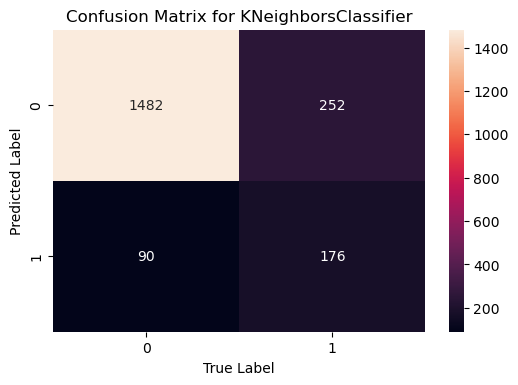

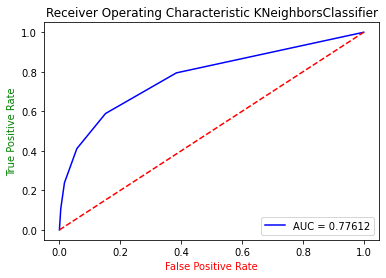

In [34]:
model_evaluate(classifier)

We need to decrease False Negatives as possible.

# Comparing Error Rate with the K Value

In [35]:
import numpy as np

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

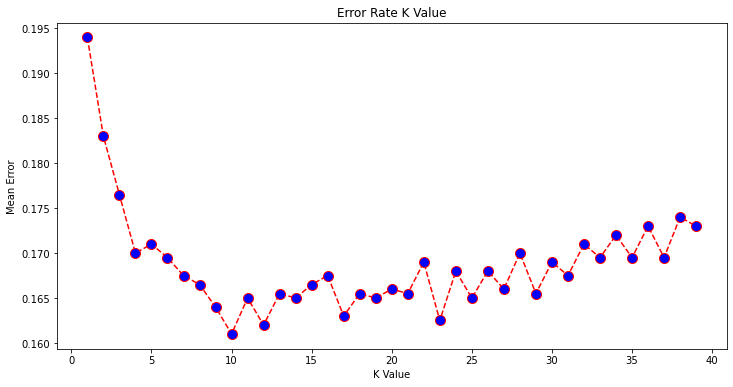

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [37]:
neighbors = np.arange(1, 40)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a KNN classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

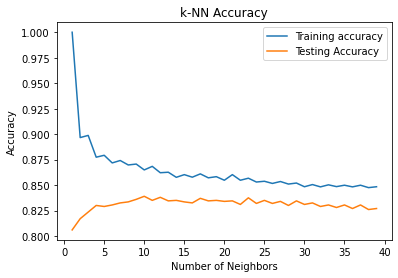

In [38]:
plt.title('k-NN Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

# Hyperparameter Tuning

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_neighbors": list(np.arange(1, 40))},
]

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5,
                          scoring="accuracy",
                          return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='accuracy')

In [40]:
print(grid_search.best_params_)

{'n_neighbors': 23}


In [41]:
# Hyperparameter Tuning

classifier = KNeighborsClassifier(n_neighbors=23)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=23)

Accuracy Score: 0.8375
Classification Report

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1572
           1       0.79      0.32      0.46       428

    accuracy                           0.84      2000
   macro avg       0.82      0.65      0.68      2000
weighted avg       0.83      0.84      0.81      2000




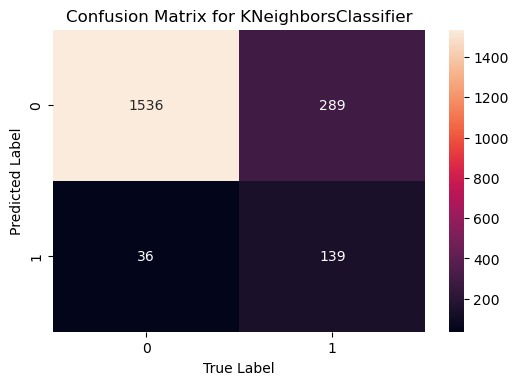

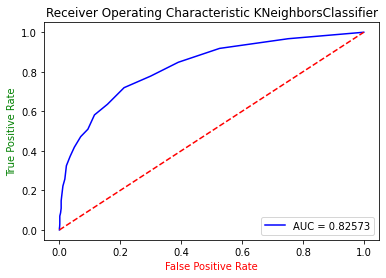

In [42]:
model_evaluate(classifier)

False Positives now decreased from 90 to 36 and accuracy increased from 83% to 84%. Also AUC became 0.82 instead of 0.77.

# Save The Model

In [43]:
import joblib

# Store model
joblib.dump(classifier, "classifier.pkl")

['classifier.pkl']